# Classification by Neural Network

![](banner_nn.jpg)

_<p style="text-align: center;"> The cuttlefish nervous system can change the animal's shape and color in less than a second.   </p>_

In [1]:
f = "setup.R"; for (i in 1:10) { if (file.exists(f)) break else f = paste0("../", f) }; source(f)

options(digits=10, scipen=100) # expose many digits, use scientific notation sparingly
update_geom_defaults("point", list(size=3, colour="grey50"))
update_geom_defaults("path", list(color="black"))

.................................................... start of document ....................................................

## Introduction

## Terms

* **Neural Network or Neural Network Model**
* **Back-Propagation Method:** a specific method to find weights for a multi-layer neural network model

## About the 2-Layer Neural Network Model

A 2-layer neural network model is an extension of the perceptron model.

### Form

A 2-layer neural network model comprises ...
* Input nodes
* Output node
* **1 layer** of **hidden** nodes, **2 layers** of **hidden** weights
* Connections (between input, hidden, and output nodes)
* Weights (one weight on each connection)
* Activation function (on hidden and output nodes, to rescale values into a range that can be interpretted as probabilities)

weights layer 1 
 
 
 
 to_hidden_1 
 to_hidden_2 
 
 
 
 
 from_1 
 0.3855288178 
 -0.6534971735 
 
 
 from_input_x1 
 0.5094660175 
 0.4058874558 
 
 
 from_input_x2 
 -0.3093033147 
 -2.0179559677 
 
 
 
 weights layer 2 
 
 
 
 to_output 
 
 
 
 
 from_1 
 0.9550985511 
 
 
 from_hidden1 
 0.0488158948 
 
 
 from_hidden2 
 0.0408402561

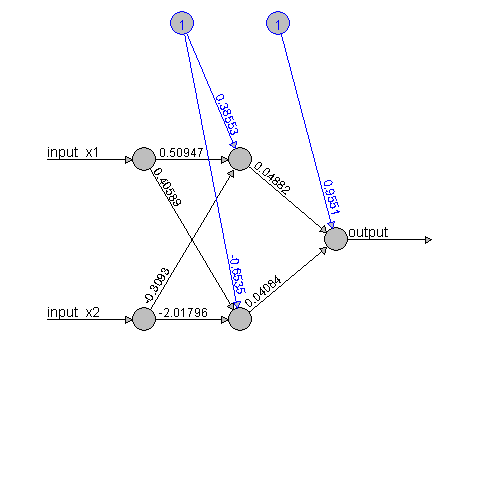

In [2]:
set.seed(12345)

ann = data.frame(input_x1=1, input_x2=1, output=1)
model = neuralnet(output ~ input_x1+input_x2, ann, hidden=2)

d1 = as.data.frame(model$weights[[1]][[1]]); names(d1) = c("to_hidden_1", "to_hidden_2"); rownames(d1) = c("from_1","from_input_x1", "from_input_x2")
d2 = as.data.frame(model$weights[[1]][[2]]); names(d2) = "to_output"; rownames(d2) = c("from_1", "from_hidden1", "from_hidden2")
layout(fmt(d1, "weights layer 1", TRUE), fmt(d2, "weights layer 2", TRUE))

output_size(4,4)
plot(model, rep=1, fill="gray", show.weights=TRUE, information=FALSE, cex=0.7, lwd=0.5)
output_size(restore)

### Choice of Activation Function

Popular choices of activation function include ... 
* sigmoid function
* hyperbolic tangent function

**Sigmoid Function**

A sigmoid activation function rescales any incoming value into range 0 to 1.  The sigmoid function is also known as the logistic function.

sigmoid:  $\large \frac{1}{1+{e}^{âˆ’x}}$

sigmoid range: $0 < sigmoid(x) < 1$, for any $x$

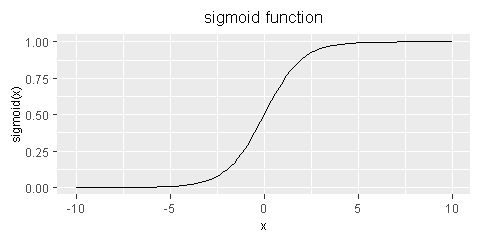

In [3]:
output_size(4,2)
ggplot(data.frame(0)) + ggtitle("sigmoid function") + xlab("x") + ylab("sigmoid(x)") + xlim(-10,10) +
stat_function(fun=sigmoid)  
output_size(restore)

**Hyperbolic Tangent Function**

A hyperbolic tangent activation function rescales any incoming value into range -1 to 1.

tanh:  $\large \frac{e^{2x}-1}{e^{2x}+1}$

tanh range: $-1 < tanh(x) < 1$, for any $x$

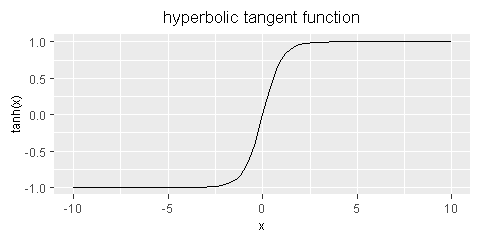

In [4]:
output_size(4,2)
ggplot(data.frame(0)) + ggtitle("hyperbolic tangent function") + xlab("x") + ylab("tanh(x)") + xlim(-10,10) +
stat_function(fun=tanh)  
output_size(restore)

### Computing Weights

To compute weights for a neural network model, apply a neural network method.  Popular neural network methods include ...
* Back-propagation method (backprop)
* Resilient back-propagation with weight backtracking method (rprop+)
* Resilient back-propagation without weight backtracking method (rprop-)
* Modified globally convergent with smallest absolute gradient method (grprop-sag)
* Modified globally convergent with smallest learning rate method (grprop-slr)

### Computing Ouput

Compute each hidden node's output as the activation function applied to the weighted sum of its node inputs, and compute the output node's output as the activation function applied to the weighted sum of the hidden nodes' outputs.

$r_i = f(w_{i0} + \sum{w_{ij}x_{ij}})$

where ...
* $r_i$ is the output of node $i$
* $f$ is the activation function
* $w_{i0}$ is an offset value for node $i$
* $w_{ij}$ is the $j^{th}$ weight for node $i$
* $x_{ij}$ is the $j^{th}$ input to node $i$

### Predicting 

To classify a new observation ...
* Use the new observation as input to the neural network model
* Compute the output
* Interpret the output as a probability and combine with a cutoff to predict the new observation's class

## About the Back-Propagation Method

The back-propoagation method calculates weights for a neural network model.

* Configure
* Initialize
* Do the following many times ...
  * Randomly reorder the observations
  * For each observation ...
    * Find error
    * Find effects of 2nd layer of weights
    * Find effects of 1st layer of weights
    * Adjust weights
* Set the model's weights

## Back-Propagation

### Data

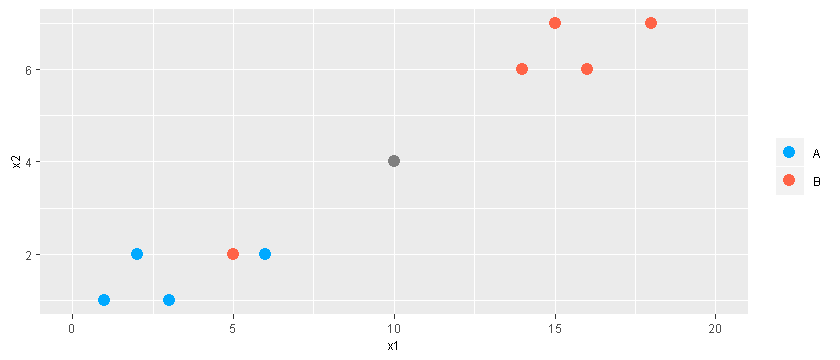

In [5]:
data = data.frame(x1=c(1,2,3,5,6,14,15,16,18), x2=c(1,2,1,2,2,6,7,6,7), class=c("A", "A", "A", "B", "A", "B", "B", "B", "B"))
new = data.frame(x1=10, x2=4)

ggplot(data) + xlim(0,20) +
geom_point(aes(x=x1, y=x2, color=class)) + geom_point(aes(x=x1, y=x2), data=new)

### Configure

Here, we choose the configuration to be ...

* Learning rate: 0.1
* Number of hidden nodes: 2
* Activation function: sigmoid
* Cutoff for A: 0.5


* Error function: $\frac{1}{2}\big(\hat{y} - y\big)^2$

### Initialize

Here, we randomly assign weights like this.

In [6]:
# Configure & initialize back-propagation method

set.seed(12345)

learning_rate = 0.1
cutoff.A = 0.5
iteration = 0
status = data.frame(x1=data$x1, x2=data$x2, class=data$class, class.bin=as.binary(data$class, "A"),
                    w.1h1=NA, w.x1h1=NA, w.x2h1=NA, w.1h2=NA, w.x1h2=NA, w.x2h2=NA, w.1out=NA, w.h1out=NA, w.h2out=NA,
                    h1=NA, h2=NA, out=NA, error=NA,
                    cutoff.A, class.predicted=NA)
w.1h1  = runif(1); w.x1h1  = runif(1); w.x2h1  = runif(1)
w.1h2  = runif(1); w.x1h2  = runif(1); w.x2h2  = runif(1)
w.1out = runif(1); w.h1out = runif(1); w.h2out = runif(1)

fmt(data.frame(w.1h1, w.x1h1, w.x2h1, w.1h2, w.x1h2, w.x2h2, w.1out, w.h1out, w.h2out), "Initial weights:", position="left")
fmt(status, "Status at iteration 0:", position="left")

Initial weights: 
 
 
 w.1h1 
 w.x1h1 
 w.x2h1 
 w.1h2 
 w.x1h2 
 w.x2h2 
 w.1out 
 w.h1out 
 w.h2out 
 
 
 
 
 0.7209038963 
 0.8757731931 
 0.7609823283 
 0.8861245662 
 0.4564809601 
 0.1663717851 
 0.3250953867 
 0.5092243357 
 0.7277052538

Status at iteration 0: 
 
 
 x1 
 x2 
 class 
 class.bin 
 w.1h1 
 w.x1h1 
 w.x2h1 
 w.1h2 
 w.x1h2 
 w.x2h2 
 w.1out 
 w.h1out 
 w.h2out 
 h1 
 h2 
 out 
 error 
 cutoff.A 
 class.predicted 
 
 
 
 
 1 
 1 
 A 
 1 
 NA 
 NA 
 NA 
 NA 
 NA 
 NA 
 NA 
 NA 
 NA 
 NA 
 NA 
 NA 
 NA 
 0.5 
 NA 
 
 
 2 
 2 
 A 
 1 
 NA 
 NA 
 NA 
 NA 
 NA 
 NA 
 NA 
 NA 
 NA 
 NA 
 NA 
 NA 
 NA 
 0.5 
 NA 
 
 
 3 
 1 
 A 
 1 
 NA 
 NA 
 NA 
 NA 
 NA 
 NA 
 NA 
 NA 
 NA 
 NA 
 NA 
 NA 
 NA 
 0.5 
 NA 
 
 
 5 
 2 
 B 
 0 
 NA 
 NA 
 NA 
 NA 
 NA 
 NA 
 NA 
 NA 
 NA 
 NA 
 NA 
 NA 
 NA 
 0.5 
 NA 
 
 
 6 
 2 
 A 
 1 
 NA 
 NA 
 NA 
 NA 
 NA 
 NA 
 NA 
 NA 
 NA 
 NA 
 NA 
 NA 
 NA 
 0.5 
 NA 
 
 
 14 
 6 
 B 
 0 
 NA 
 NA 
 NA 
 NA 
 NA 
 NA 
 NA 
 NA 
 NA 
 NA 
 NA 
 NA 
 NA 
 0.5 
 NA 
 
 
 15 
 7 
 B 
 0 
 NA 
 NA 
 NA 
 NA 
 NA 
 NA 
 NA 
 NA 
 NA 
 NA 
 NA 
 NA 
 NA 
 0.5 
 NA 
 
 
 16 
 6 
 B 
 0 
 NA 
 NA 
 NA 
 NA 
 NA 
 NA 
 NA 
 NA 
 NA 
 NA 
 NA 
 NA 
 NA 
 0.5 
 NA 
 
 
 18 
 7 
 B 
 0 
 NA 
 NA 
 NA 
 NA 
 NA 
 NA 
 NA 
 NA 
 NA 
 NA 
 NA 
 NA 
 NA 
 0.5 
 NA

### Iterate

Then, we adjust weights of each observation in the training data 1000 times.

Note that the neural network model with adjusted weights after 1000 iterations correctly predicts 9 out of 10 observations in the training data.

In [7]:
# Configure & initialize back-propagation method

set.seed(12345)
learning_rate = 0.1
cutoff.A = 0.5
iteration = 0
status = data.frame(x1=data$x1, x2=data$x2, class=data$class, class.bin=as.binary(data$class, "A"),
                    w.1h1=NA, w.x1h1=NA, w.x2h1=NA, w.1h2=NA, w.x1h2=NA, w.x2h2=NA, w.1out=NA, w.h1out=NA, w.h2out=NA,
                    h1=NA, h2=NA, out=NA, error=NA,
                    cutoff.A, class.predicted=NA)
w.1h1  = runif(1); w.x1h1  = runif(1); w.x2h1  = runif(1)
w.1h2  = runif(1); w.x1h2  = runif(1); w.x2h2  = runif(1)
w.1out = runif(1); w.h1out = runif(1); w.h2out = runif(1)


# Iterate back-propagation method

set.seed(12345)

for (iteration in 1:1000)

  { # randomize order of observations
    status = status[sample(nrow(status)),]
    
    # process each observation
    for (obs in 1:nrow(data))
        
      { x1 = status$x1[obs]
        x2 = status$x2[obs]
        class.bin = status$class.bin[obs]
       
        # find error
        zh1  = w.1h1*1  + w.x1h1*x1  + w.x2h1*x2;  h1  = sigmoid(zh1)
        zh2  = w.1h2*1  + w.x1h2*x1  + w.x2h2*x2;  h2  = sigmoid(zh2)
        zout = w.1out*1 + w.h1out*h1 + w.h2out*h2; out = sigmoid(zout)
        error = 0.5 * (out - class.bin)^2
       
       # update status report
        status$w.1h1[obs]  = w.1h1;  status$w.x1h1[obs]  = w.x1h1;  status$w.x2h1[obs]  = w.x2h1
        status$w.1h2[obs]  = w.1h2;  status$w.x1h2[obs]  = w.x1h2;  status$w.x2h2[obs]  = w.x2h2
        status$w.1out[obs] = w.1out; status$w.h1out[obs] = w.h1out; status$w.h2out[obs] = w.h2out
        status$h1[obs] = h1; status$h2[obs] = h2
        status$out[obs] = out
        status$error[obs] = error
        status$class.predicted[obs] = as.character(as.class(data.frame("A"=out, "B"=1-out), "A", cutoff.A))
       
        # find effects of 2nd layer of weights 
        dE_dout = out - class.bin
        dout_dzout = out * (1 - out)
        dzout_dw.h1out = h1
        dzout_dw.h2out = h2
        dE_dw.h1out = dE_dout * dout_dzout * dzout_dw.h1out
        dE_dw.h2out = dE_dout * dout_dzout * dzout_dw.h2out
        dE_dw.1out  = dE_dout * dout_dzout * 1
       
        # find effects of 1st layer of weights
        dzout_dh1 = w.h1out
        dE_dh1 = dE_dout * dout_dzout * dzout_dh1
        dh1_dzh1 = h1 * (1 - h1)
        dzh1_dw.x1h1 = x1
        dzh1_dw.x2h1 = x2
        dE_dw.x1h1 = dE_dh1 * dh1_dzh1 * dzh1_dw.x1h1        
        dE_dw.x2h1 = dE_dh1 * dh1_dzh1 * dzh1_dw.x2h1
        dE_dw.1h1  = dE_dh1 * dh1_dzh1 * 1
       
        dzout_dh2 = w.h2out
        dE_dh2 = dE_dout * dout_dzout * dzout_dh2
        dh2_dzh2 = h2 * (1 - h2)
        dzh2_dw.x1h2 = x1
        dzh2_dw.x2h2 = x2
        dE_dw.x1h2 = dE_dh2 * dh2_dzh2 * dzh2_dw.x1h2        
        dE_dw.x2h2 = dE_dh2 * dh2_dzh2 * dzh2_dw.x2h2
        dE_dw.1h2  = dE_dh2 * dh2_dzh2 * 1
        
        # adjust weights
        w.1h1 = w.1h1 - learning_rate*dE_dw.1h1
        w.x1h1 = w.x1h1 - learning_rate*dE_dw.x1h1
        w.x2h1 = w.x2h1 - learning_rate*dE_dw.x2h1
        w.1h2 = w.1h2 - learning_rate*dE_dw.1h2
        w.x1h2 = w.x1h2 - learning_rate*dE_dw.x1h2
        w.x2h2 = w.x2h2 - learning_rate*dE_dw.x2h2
        w.1out = w.1out - learning_rate*dE_dw.1out
        w.h1out = w.h1out - learning_rate*dE_dw.h1out
        w.h2out = w.h2out - learning_rate*dE_dw.h2out }

    if (iteration %in% list(1,2,1000)) fmt(status, sprintf("Status at iteration %d:", iteration), position="left") }

Status at iteration 1: 
 
 
 x1 
 x2 
 class 
 class.bin 
 w.1h1 
 w.x1h1 
 w.x2h1 
 w.1h2 
 w.x1h2 
 w.x2h2 
 w.1out 
 w.h1out 
 w.h2out 
 h1 
 h2 
 out 
 error 
 cutoff.A 
 class.predicted 
 
 
 
 
 3 
 1 
 A 
 1 
 0.7209038963 
 0.8757731931 
 0.7609823283 
 0.8861245662 
 0.4564809601 
 0.1663717851 
 0.3250953867 
 0.5092243357 
 0.7277052538 
 0.9838444761 
 0.9184850532 
 0.8167496446 
 0.0167903464 
 0.5 
 A 
 
 
 16 
 6 
 B 
 0 
 0.7209260954 
 0.8758397904 
 0.7610045274 
 0.8862739981 
 0.4569292560 
 0.1665212171 
 0.3278380886 
 0.5119227278 
 0.7302243844 
 0.9999999959 
 0.9998985932 
 0.8277709415 
 0.3426023658 
 0.5 
 A 
 
 
 2 
 2 
 A 
 1 
 0.7209260953 
 0.8758397900 
 0.7610045273 
 0.8862731244 
 0.4569152754 
 0.1665159743 
 0.3160368720 
 0.5001215112 
 0.7184243646 
 0.9819184243 
 0.8940823163 
 0.8099131456 
 0.0180665061 
 0.5 
 A 
 
 
 5 
 2 
 B 
 0 
 0.7209520808 
 0.8758917608 
 0.7610564981 
 0.8864722236 
 0.4573134739 
 0.1669141728 
 0.3189633322 
 0.5029950564 
 0.7210408609 
 0.9986716970 
 0.9708825524 
 0.8207351659 
 0.3368031063 
 0.5 
 A 
 
 
 15 
 7 
 B 
 0 
 0.7209440235 
 0.8758514748 
 0.7610403837 
 0.8862260843 
 0.4560827771 
 0.1664218941 
 0.3068879416 
 0.4909357056 
 0.7093170748 
 0.9999999953 
 0.9998625923 
 0.8186226038 
 0.3350714837 
 0.5 
 A 
 
 
 1 
 1 
 A 
 1 
 0.7209440235 
 0.8758514743 
 0.7610403835 
 0.8862248997 
 0.4560650093 
 0.1664136025 
 0.2947330629 
 0.4787808270 
 0.6971638663 
 0.9135550531 
 0.8188689878 
 0.7863413901 
 0.0228250008 
 0.5 
 A 
 
 
 18 
 7 
 B 
 0 
 0.7210797495 
 0.8759872003 
 0.7611761095 
 0.8865960878 
 0.4564361974 
 0.1667847906 
 0.2983227115 
 0.4820601686 
 0.7001033182 
 0.9999999997 
 0.9999653418 
 0.8146423429 
 0.3318210735 
 0.5 
 A 
 
 
 6 
 2 
 A 
 1 
 0.7210797495 
 0.8759872003 
 0.7611761095 
 0.8865957894 
 0.4564308250 
 0.1667827013 
 0.2860215962 
 0.4697590532 
 0.6878026292 
 0.9994468650 
 0.9812704596 
 0.8069700523 
 0.0186302804 
 0.5 
 A 
 
 
 14 
 6 
 B 
 0 
 0.7210805304 
 0.8759918854 
 0.7611776712 
 0.8866337984 
 0.4566588790 
 0.1668587193 
 0.2890284118 
 0.4727642057 
 0.6907531286 
 0.9999999762 
 0.9997467830 
 0.8103630380 
 0.3283441267 
 0.5 
 A

Status at iteration 2: 
 
 
 x1 
 x2 
 class 
 class.bin 
 w.1h1 
 w.x1h1 
 w.x2h1 
 w.1h2 
 w.x1h2 
 w.x2h2 
 w.1out 
 w.h1out 
 w.h2out 
 h1 
 h2 
 out 
 error 
 cutoff.A 
 class.predicted 
 
 
 
 
 16 
 6 
 B 
 0 
 0.7210805302 
 0.8759918835 
 0.7611776704 
 0.8866316207 
 0.4566283919 
 0.1668456534 
 0.2765751753 
 0.4603109695 
 0.6783030454 
 0.9999999959 
 0.9998983385 
 0.8045722826 
 0.3236682789 
 0.5 
 A 
 
 
 1 
 1 
 A 
 1 
 0.7210805302 
 0.8759918831 
 0.7611776702 
 0.8866307485 
 0.4566144355 
 0.1668404198 
 0.2639244247 
 0.4476602189 
 0.6656535809 
 0.9135877580 
 0.8190738930 
 0.7717326744 
 0.0260529860 
 0.5 
 A 
 
 
 2 
 2 
 A 
 1 
 0.7212226414 
 0.8761339943 
 0.7613197815 
 0.8870274163 
 0.4570111034 
 0.1672370876 
 0.2679456128 
 0.4513339272 
 0.6689472311 
 0.9819453111 
 0.8943082616 
 0.7874086996 
 0.0225975305 
 0.5 
 A 
 
 
 6 
 2 
 A 
 1 
 0.7212511166 
 0.8761909447 
 0.7613767318 
 0.8872524312 
 0.4574611332 
 0.1676871175 
 0.2715043112 
 0.4548283744 
 0.6721298045 
 0.9994478565 
 0.9814287269 
 0.7999095354 
 0.0200180970 
 0.5 
 A 
 
 
 14 
 6 
 B 
 0 
 0.7212519204 
 0.8761957676 
 0.7613783394 
 0.8872916638 
 0.4576965289 
 0.1677655827 
 0.2747068446 
 0.4580291395 
 0.6752728628 
 0.9999999763 
 0.9997519511 
 0.8034252423 
 0.3227460599 
 0.5 
 A 
 
 
 3 
 1 
 A 
 1 
 0.7212519203 
 0.8761957656 
 0.7613783386 
 0.8872895390 
 0.4576667811 
 0.1677528336 
 0.2620180988 
 0.4453403941 
 0.6625872645 
 0.9838764208 
 0.9189408570 
 0.7873552348 
 0.0226088981 
 0.5 
 A 
 
 
 18 
 7 
 B 
 0 
 0.7212770724 
 0.8762712219 
 0.7614034907 
 0.8874652556 
 0.4581939308 
 0.1679285502 
 0.2655783457 
 0.4488432370 
 0.6658589208 
 0.9999999997 
 0.9999667178 
 0.7990324879 
 0.3192264584 
 0.5 
 A 
 
 
 15 
 7 
 B 
 0 
 0.7212770724 
 0.8762712219 
 0.7614034907 
 0.8874649712 
 0.4581888128 
 0.1679265599 
 0.2527475163 
 0.4360124076 
 0.6530285184 
 0.9999999954 
 0.9998684225 
 0.7927697802 
 0.3142419622 
 0.5 
 A 
 
 
 5 
 2 
 B 
 0 
 0.7212770724 
 0.8762712215 
 0.7614034905 
 0.8874638523 
 0.4581720288 
 0.1679187273 
 0.2397234301 
 0.4229883214 
 0.6400061459 
 0.9986755599 
 0.9710880307 
 0.7830710983 
 0.3066001725 
 0.5 
 A

Status at iteration 1000: 
 
 
 x1 
 x2 
 class 
 class.bin 
 w.1h1 
 w.x1h1 
 w.x2h1 
 w.1h2 
 w.x1h2 
 w.x2h2 
 w.1out 
 w.h1out 
 w.h2out 
 h1 
 h2 
 out 
 error 
 cutoff.A 
 class.predicted 
 
 
 
 
 14 
 6 
 B 
 0 
 0.8627696341 
 1.078287261 
 0.9213289823 
 -3.229118945 
 0.1778651619 
 0.6127990816 
 1.367947755 
 0.7817380484 
 -4.763952691 
 0.9999999995 
 0.9496831222 
 0.0851333347 
 0.0036238423 
 0.5 
 B 
 
 
 18 
 7 
 B 
 0 
 0.8627696341 
 1.078287261 
 0.9213289823 
 -3.228968001 
 0.1799783832 
 0.6137047478 
 1.367284689 
 0.7810749819 
 -4.764582394 
 1.0000000000 
 0.9866996604 
 0.0722351083 
 0.0026089554 
 0.5 
 B 
 
 
 15 
 7 
 B 
 0 
 0.8627696341 
 1.078287261 
 0.9213289823 
 -3.228937731 
 0.1805232365 
 0.6139166353 
 1.366800589 
 0.7805908824 
 -4.765060055 
 0.9999999999 
 0.9776062978 
 0.0750933194 
 0.0028195033 
 0.5 
 B 
 
 
 16 
 6 
 B 
 0 
 0.8627696341 
 1.078287261 
 0.9213289823 
 -3.228883324 
 0.1813393491 
 0.6142974878 
 1.366279034 
 0.7800693270 
 -4.765569931 
 0.9999999999 
 0.9663765944 
 0.0787838350 
 0.0031034463 
 0.5 
 B 
 
 
 2 
 2 
 A 
 1 
 0.8627696341 
 1.078287261 
 0.9213289823 
 -3.228794784 
 0.1827559865 
 0.6148287268 
 1.365707245 
 0.7794975380 
 -4.766122494 
 0.9923243887 
 0.1633343287 
 0.7958816051 
 0.0208321596 
 0.5 
 A 
 
 
 5 
 2 
 B 
 0 
 0.8627893217 
 1.078326637 
 0.9213683576 
 -3.230954553 
 0.1784364478 
 0.6105091881 
 1.369023231 
 0.7827880723 
 -4.765580880 
 0.9996956900 
 0.2464281426 
 0.7265522520 
 0.2639390874 
 0.5 
 A 
 
 
 3 
 1 
 A 
 1 
 0.8627858843 
 1.078309449 
 0.9213614827 
 -3.218180201 
 0.2423082074 
 0.6360578920 
 1.354588522 
 0.7683577551 
 -4.769137998 
 0.9934327795 
 0.1352637832 
 0.8134839122 
 0.0173941255 
 0.5 
 A 
 
 
 6 
 2 
 A 
 1 
 0.8628000705 
 1.078352008 
 0.9213756689 
 -3.219758854 
 0.2375722490 
 0.6344792391 
 1.357418490 
 0.7711691383 
 -4.768755206 
 0.9998964822 
 0.3715981360 
 0.5881801430 
 0.0847977973 
 0.5 
 A 
 
 
 1 
 1 
 A 
 1 
 0.8628008667 
 1.078356785 
 0.9213772614 
 -3.230866984 
 0.1709234701 
 0.6122629795 
 1.367393766 
 0.7811433818 
 -4.765048412 
 0.9459630232 
 0.0796083328 
 0.8490268701 
 0.0113964430 
 0.5 
 A

### Results

The model weights are then set to be the weights calculated based on the last observation of the last iteration. 

In [8]:
fmt(data.frame(w.1h1, w.x1h1, w.x2h1, w.1h2, w.x1h2, w.x2h2, w.1out, w.h1out, w.h2out), "Final weights:", position="left")

Final weights: 
 
 
 w.1h1 
 w.x1h1 
 w.x2h1 
 w.1h2 
 w.x1h2 
 w.x2h2 
 w.1out 
 w.h1out 
 w.h2out 
 
 
 
 
 0.8628781377 
 1.078434056 
 0.9214545324 
 -3.23154263 
 0.170247824 
 0.6115873334 
 1.369328943 
 0.7829739879 
 -4.764894356

weights layer 1 
 
 
 
 to_hidden_1 
 to_hidden_2 
 
 
 
 
 from_1 
 0.8628781377 
 -3.2315426300 
 
 
 from_input_x1 
 1.0784340564 
 0.1702478240 
 
 
 from_input_x2 
 0.9214545324 
 0.6115873334 
 
 
 
 weights layer 2 
 
 
 
 to_output 
 
 
 
 
 from_1 
 1.3693289433 
 
 
 from_hidden1 
 0.7829739879 
 
 
 from_hidden2 
 -4.7648943560

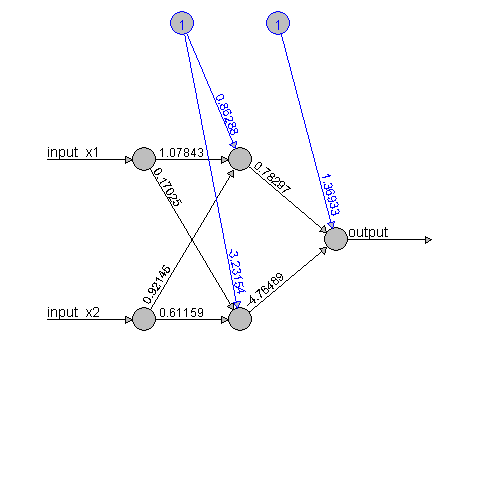

In [9]:
ann = data.frame(input_x1=1, input_x2=1, output=1)
model = neuralnet(output ~ input_x1+input_x2, ann, hidden=2)
model$weights[[1]][[1]][,1] = c(w.1h1, w.x1h1, w.x2h1)
model$weights[[1]][[1]][,2] = c(w.1h2, w.x1h2, w.x2h2)
model$weights[[1]][[2]][,1] = c(w.1out, w.h1out, w.h2out)

d1 = as.data.frame(model$weights[[1]][[1]]); names(d1) = c("to_hidden_1", "to_hidden_2"); rownames(d1) = c("from_1","from_input_x1", "from_input_x2")
d2 = as.data.frame(model$weights[[1]][[2]]); names(d2) = "to_output"; rownames(d2) = c("from_1", "from_hidden1", "from_hidden2")
layout(fmt(d1, "weights layer 1", TRUE), fmt(d2, "weights layer 2", TRUE))

output_size(4,4)
plot(model, rep=1, fill="gray", show.weights=TRUE, information=FALSE, cex=0.7, lwd=0.5)
output_size(restore)

### Prediction

Use the model to predict the new observation's class.

In [10]:
zh1  = w.1h1*1  + w.x1h1*new$x1  + w.x2h1*new$x2;  h1  = sigmoid(zh1)
zh2  = w.1h2*1  + w.x1h2*new$x1  + w.x2h2*new$x2;  h2  = sigmoid(zh2)
zout = w.1out*1 + w.h1out*h1 + w.h2out*h2; out = sigmoid(zout)

class.predicted = as.class(data.frame("A"=out, "B"=1-out), "A", cutoff.A)

fmt(data.frame(x1=new$x1, x2=new$x2, out, cutoff.A, class.predicted), "new observation")

new observation 
 
 
 x1 
 x2 
 out 
 cutoff.A 
 class.predicted 
 
 
 
 
 10 
 4 
 0.2223264908 
 0.5 
 B

## Resilient Back-Propagation with Weight Backtracking Method

There are several popular variations of the back-propagation method.  Here, we use the resilient back-progation with weight backtracking method to compute weights for a 2-layer neural network model with 2 hidden nodes.

### Data

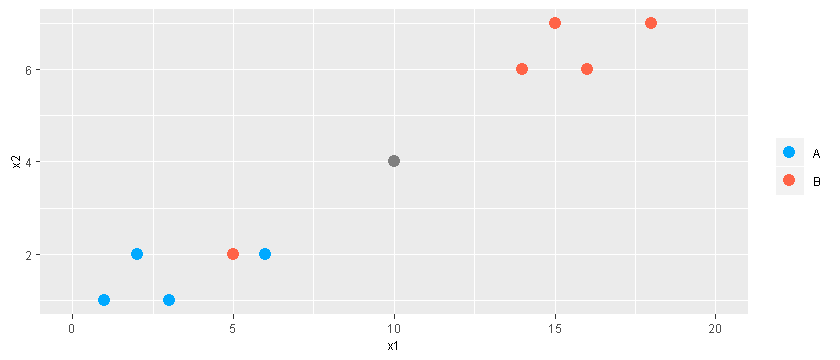

In [11]:
data = data.frame(x1=c(1,2,3,5,6,14,15,16,18), x2=c(1,2,1,2,2,6,7,6,7), class=c("A", "A", "A", "B", "A", "B", "B", "B", "B"))
new = data.frame(x1=10, x2=4)

ggplot(data) + xlim(0,20) +
geom_point(aes(x=x1, y=x2, color=class)) + geom_point(aes(x=x1, y=x2), data=new)

### Results

weights layer 1 
 
 
 
 to_hidden_1 
 to_hidden_2 
 
 
 
 
 
 -6.3512711822 
 -5.3198124825 
 
 
 from_input_x1 
 0.3897773136 
 1.6289815941 
 
 
 from_input_x2 
 0.2315726650 
 0.3400412795 
 
 
 
 weights layer 2 
 
 
 
 to_output 
 
 
 
 
 
 3.288653796 
 
 
 from_hidden_1 
 -5.299056047 
 
 
 from_hidden_2 
 -3.100983263

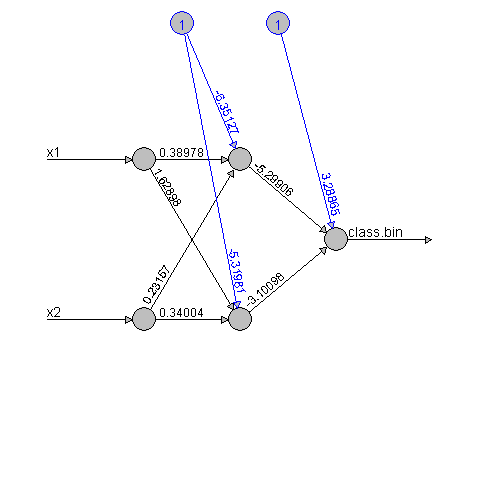

In [12]:
set.seed(12345)

data$class.bin = as.binary(data$class, "A")
model = neuralnet(class.bin ~ x1+x2, data, hidden=2, algorithm="rprop+", linear.output=FALSE, rep=1)

d1 = as.data.frame(model$weights[[1]][[1]]); names(d1) = c("to_hidden_1", "to_hidden_2"); rownames(d1) = c("","from_input_x1", "from_input_x2")
d2 = as.data.frame(model$weights[[1]][[2]]); names(d2) = "to_output"; rownames(d2) = c("", "from_hidden_1", "from_hidden_2")
layout(fmt(d1, "weights layer 1", TRUE), fmt(d2, "weights layer 2", TRUE))

output_size(4,4)
plot(model, rep=1, fill="gray", show.weights=TRUE, information=FALSE, cex=0.7, lwd=0.5)
output_size(restore)

### Prediction

Use the model to predict the new observation's class.

In [13]:
output = compute(model, new, rep=1)$net.result
class.predicted = as.class(data.frame("A"=output, "B"=1-output), "A", cutoff.A)
                           
data.frame(x1=new$x1, x2=new$x2, output, cutoff.A, class.predicted)    

x1 x2 output       cutoff.A class.predicted
1 10 4  0.3191498728 0.5      B

## About the Multi-Layer Neural Network Model

### Form

A multi-layer neural network model comprises ...
* Input nodes
* Output node
* **Many** layers of **hidden** nodes
* Connections (between input, hidden, and output nodes)
* Weights (one weight on each connection)
* Activation function (on hidden and output nodes, to rescale values into a range that can be interpretted as probabilities)

### Computing Ouput

Moving from the input side to the output side, compute each hidden node's output as the activation function applied to the weighted sum of its node inputs (which may outputs of input nodes or other hidden nodes), and compute the output node's output as the activation function applied to the weighted sum of the last layer of hidden nodes outputs.

$r_i = f(w_{i0} + \sum{w_{ij}x_{ij}})$

where ...
* $r_i$ is the output of node $i$
* $f$ is the activation function
* $w_{i0}$ is an offset value for node $i$
* $w_{ij}$ is the $j^{th}$ weight for node $i$
* $x_{ij}$ is the $j^{th}$ input to node $i$

## Classification with a Multi-Layer Neural Network

### Data

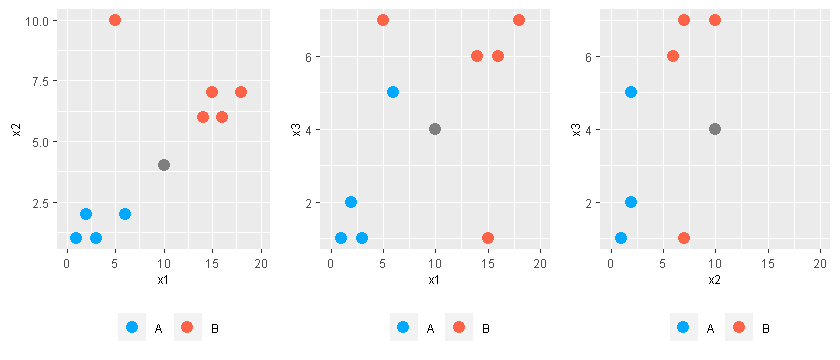

In [14]:
data = data.frame(x1=c(1,2,3,5,6,14,15,16,18), x2=c(1,2,1,10,2,6,7,6,7), x3=c(1,2,1,7,5,6,1,6,7), class=c("A", "A", "A", "B", "A", "B", "B", "B", "B"))
new = data.frame(x1=10, x2=4, x3=7)

p1 = ggplot(data) + xlim(0,20) +
     geom_point(aes(x=x1, y=x2, color=class)) + geom_point(aes(x=x1, y=x2), data=new) +
     theme.legend_below   

p2 = ggplot(data) + xlim(0,20) +
     geom_point(aes(x=x1, y=x3, color=class)) + geom_point(aes(x=x1, y=x2), data=new) +
     theme.legend_below

p3 = ggplot(data) + xlim(0,20) +
     geom_point(aes(x=x2, y=x3, color=class)) + geom_point(aes(x=x1, y=x2), data=new) +
     theme.legend_below

grid.arrange(p1, p2, p3, nrow=1)

### Build Model

[[1]]
              [,1]          [,2]
[1,] -3.2644711822  3.7242874558
[2,]  0.7639552846 -0.0200839677
[3,] -0.1843513419 -0.6572185689
[4,] -0.9640225780 -0.1555722917

[[2]]
              [,1]         [,2]
[1,] -0.9591597439  1.098634924
[2,] -3.2381220025  2.111787864
[3,]  3.9837521936 -3.579783542

[[3]]
             [,1]
[1,] -0.903414075
[2,]  4.585299840
[3,] -3.523834641

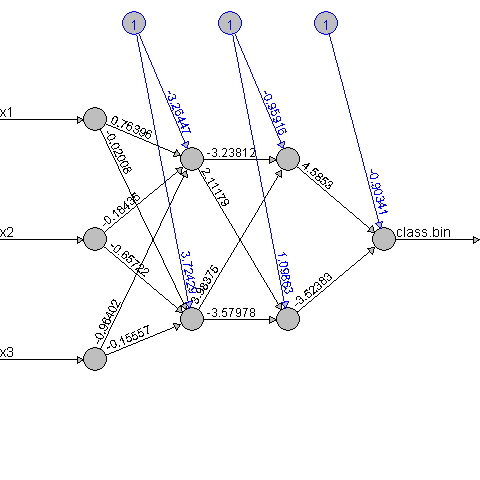

In [15]:
set.seed(12345)

data$class.bin = as.binary(data$class, "A")
model = neuralnet(class.bin ~ x1+x2+x3, data, hidden=c(2,2), algorithm="rprop+", linear.output=FALSE, rep=1)

model$weights[[1]]
output_size(4,4)
plot(model, rep=1, fill="gray", show.weights=TRUE, information=FALSE, cex=0.7, lwd=0.5)
output_size(restore)

### Prediction

Use the model to predict the new observation's class. 

In [16]:
output = compute(model, new, rep=1)$net.result
class.predicted = as.class(data.frame("A"=output, "B"=1-output), "A", cutoff.A)
                           
data.frame(x1=new$x1, x2=new$x2, x3=new$x3, output, cutoff.A, class.predicted)    

x1 x2 x3 output       cutoff.A class.predicted
1 10 4  7  0.6837683141 0.5      A

## More About the Multi-Layer Neural Network Model

* ANY function can be approximated by a multi-layer neural network with 1 hidden layer (proof by Cybenko, and later by Hornik).
* Often, a multi-layer neural network model with >1 hidden layer can approximate a multi-layer neural network model with 1 hidden layer, but use fewer nodes.
* A multi-layer neural network model with many nodes corresponds to a very complex class separation boundary.
* Building a multi-layer neural network model involves finding the node-connection weights. 
* Building a multi-layer neural network model with many layers is referred to as "deep learning".

## Hyper-Parameters for the Neural Network Method

* Activation function (sigmoid, hyperbolic tangent, or some other function)
* Number of hidden layers
* Number of hidden nodes
* Arrangement of hidden layers & nodes
* Initial weights (or randomized weights)
* Number of repetitions
* Method variation (back-propagation or some other method)
* Learning rate (if back-propagation method is used)
* Other method variation parameters (if some other method variation is used)
* Stopping criterion (threshold, maximum number of steps, and/or some other criterion)
* ... other hyper-parameters

## Code

### Useful Functions

In [17]:
# as.binary # from apparatus code cell above
# as.class # from apparatus code cell above

# help(neuralnet, package="neuralnet")
# help(predict.nn, package="neuralnet") # use predict to call thsi function
# help(plot.nn, package="neuralnet") # use plot to call this function

### More About `neuralnet`'s Hyper-Parameters

* `hidden` is the number of nodes in the hidden layer
* `algorithm="rprop+"` means use the resilient back-propagation with weight backtracking method
* `stepmax` is the maximum number of iterations allowed
* `rep` is the number of times to find weights, each time starting with a different set of random initial weights
* `linear.output=FALSE` means use the activation function on the output node (and the hidden nodes)
* `act.fct="logistic` means use the sigmoid function as the activation function
* `threshold` is a stopping criterion

### Templates

$call
neuralnet(formula = class.bin ~ x1 + x2 + x3 + x4, data = data, 
    hidden = c(3, 2, 2), rep = 1, algorithm = "rprop+", act.fct = "logistic", 
    linear.output = FALSE)

$response
  class.bin
1         1
2         0
3         1
4         0
5         1
6         0
7         1
8         0

$covariate
     x1 x2 x3 x4
[1,]  1  8  1  1
[2,]  2  7  1  3
[3,]  3  6  2  2
[4,]  4  5  2  2
[5,]  5  4  3  1
[6,]  6  3  3  3
[7,]  7  2  4  9
[8,]  8  1  4  4

$model.list
$model.list$response
[1] "class.bin"

$model.list$variables
[1] "x1" "x2" "x3" "x4"


$err.fct
function (x, y) 
{
    1/2 * (y - x)^2
}
<bytecode: 0x0000000033072948>
<environment: 0x00000000310b6050>
attr(,"type")
[1] "sse"

$act.fct
function (x) 
{
    1/(1 + exp(-x))
}
<bytecode: 0x000000003306cfb8>
<environment: 0x00000000310b5bb8>
attr(,"type")
[1] "logistic"

$linear.output
[1] FALSE

$data
  x1 x2 x3 x4 class class.bin
1  1  8  1  1     A         1
2  2  7  1  3     B         0
3  3  6  2  2     A         1
4  4  

[[1]]
               [,1]           [,2]          [,3]
[1,]  0.21712881784 -1.64955596770 -0.2846478064
[2,]  0.40946601751  0.79849855107  1.8489120437
[3,] -0.09130331468  0.09221589477  0.2022278643
[4,] -0.86349717346 -0.11575974394  0.3518164576
[5,]  0.36088745584 -1.50132200247 -0.3005319945

[[2]]
              [,1]          [,2]
[1,]  0.3918998395 -0.1262763007
[2,] -1.4683575212  0.1976219246
[3,] -0.1631775899  1.6241850825
[4,]  0.6957126517 -1.0693284292

[[3]]
             [,1]          [,2]
[1,] -2.135137405 -0.9066473637
[2,] -2.022709517  0.1953798013
[3,]  1.223097519  0.2371234927

[[4]]
              [,1]
[1,] -0.5873109769
[2,]  0.2298731786
[3,]  1.7718335463

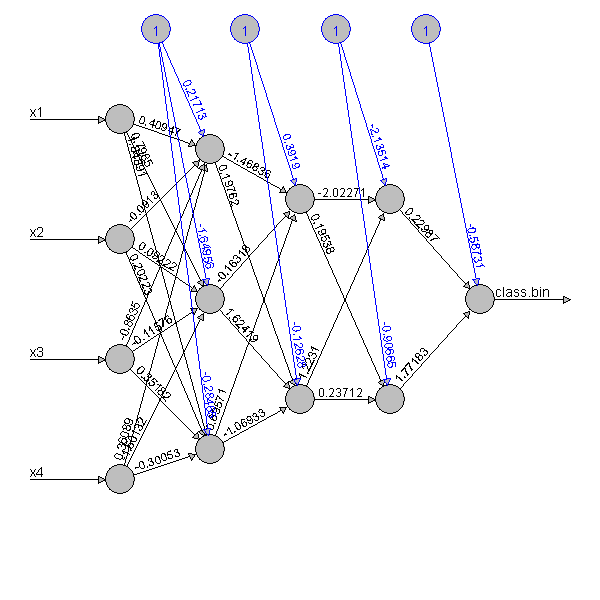

In [18]:
# Build a Multi-Layer Neural Network Model

data = data.frame(x1=c(1,2,3,4,5,6,7,8), x2=c(8,7,6,5,4,3,2,1), x3=c(1,1,2,2,3,3,4,4), x4=c(1,3,2,2,1,3,9,4), class=c("A", "B", "A", "B", "A", "B", "A", "B"))

set.seed(12345)

data$class.bin = as.binary(data$class, "A")
model = neuralnet(class.bin ~ x1+x2+x3+x4, data, hidden=c(3,2,2), algorithm="rprop+", act.fct="logistic", linear.output=FALSE, rep=1)

model
model$weights[[1]]
output_size(5,5)
plot(model, rep=1, fill="gray", show.weights=TRUE, information=FALSE, cex=0.7, lwd=0.5, arrow.length=0.15)
output_size(restore)

In [19]:
# Use a multi-layer neural network model to make predictions

data.new = data.frame(x1=c(5,6,7,8), x2=c(8,7,6,5), x3=c(1,5,2,6), x4=c(3,4,6,1))
cutoff.A = 0.6

output = compute(model, data.new, rep=1)$net.result
prob = data.frame("A"=output, "B"=1-output)
class.predicted = as.class(prob, "A", cutoff.A)

cbind(data.new, class.predicted)

x1 x2 x3 x4 class.predicted
1 5  8  1  3  B              
2 6  7  5  4  B              
3 7  6  2  6  B              
4 8  5  6  1  B

## Expectations

Know about this:
* How the perceptron method works, conceptuallly
* How to determine weights for a 1-layer neural network model using the perceptron method, mechanically 
* How to interpret weights determined by R's `neuralnet` function, conceptually
* How to compute outputs and classify new observations, given a multi-layer neural network model with activation function, weights, and cutoff, mechanically
* How to build a multi-layer neural network model and use it to classify new observations, using R's `neuralnet` and `compute` functions

## Further Reading

* https://www.anotsorandomwalk.com/backpropagation-example-with-numbers-step-by-step/
* https://google-developers.appspot.com/machine-learning/crash-course/backprop-scroll/
* https://mattmazur.com/2015/03/17/a-step-by-step-backpropagation-example/
* https://www.youtube.com/watch?v=pgDE2DOICuc
* http://ciml.info/dl/v0_99/ciml-v0_99-ch04.pdf
* http://ciml.info/dl/v0_99/ciml-v0_99-ch10.pdf
* http://blog.refu.co/?p=935
* http://blog.refu.co/?p=931
* https://en.wikipedia.org/wiki/Perceptron
* https://en.wikipedia.org/wiki/Multilayer_perceptron
* https://www.r-bloggers.com/using-neural-networks-for-credit-scoring-a-simple-example/
* https://datascienceplus.com/fitting-neural-network-in-r/
* http://www.learnbymarketing.com/tutorials/neural-networks-in-r-tutorial/
* https://cran.r-project.org/web/packages/neuralnet/neuralnet.pdf
* http://www-stat.wharton.upenn.edu/~stine/mich/DM_06.pdf
* https://www.r-bloggers.com/multilabel-classification-with-neuralnet-package/
* https://www.digitaljunky.io/playing-around-with-neural-networks-and-r/
* https://stackoverflow.com/questions/26047901/r-error-in-nroww-ncolw-non-numeric-argument-to-binary-operator-while-u

## Appendix: More About the Back-Propagation Method

_**Configure:**_
* Choose the learning rate.
* Choose the number of hidden nodes.
* Choose the activation function to be the sigmoid function.
* Choose a cutoff value (in range 0 to 1).
* Choose the error function to be half squared difference.

_**Initialize:**_
* Convert class values to binary (0 or 1).
* Assign random weights to connections.

_**Iterate:**_ 
* Do the following many times ...<br/><br/>
  * Randomly reorder the training data observations.<br/><br/>
  * For each observation ...<br/><br/>
    
    * Compute the output and error ...<br/><br/>
      * $zh1 = (w_{1 \rightarrow h1})(1) + (w_{x1 \rightarrow h1})(x1) + (w_{x2 \rightarrow h1})(x2)$<br/><br/>
      * $zh2 = (w_{1 \rightarrow h2})(1) + (w_{x1 \rightarrow h2})(x1) + (w_{x2 \rightarrow h2})(x2)$<br/><br/>
      * $zout = (w_{1 \rightarrow out})(1) + (w_{h1 \rightarrow out})(h1) + (w_{h2 \rightarrow out})(h2)$<br/><br/>
      * $h1 = sigmoid(zh1)$ <br/><br/>
      * $h2 = sigmoid(zh2)$<br/><br/>
      * $out = sigmoid(zout)$<br/><br/>
      * $E = \frac{1}{2}(out - class.bin)^2$<br/><br/>
    
    * Find effects of 2nd layer of weights ...<br/><br/>
      * $\frac{\partial E}{\partial out} = out - class.bin$ (from calculus applied to error function, how change in **out** affects change in **E**)<br/><br/>
      * $\frac{\partial out}{\partial zout} = (out)(1 - out)$ (from calculus applied to sigmoid function, how change in **zout** affects change in **out**)<br/><br/>
      * $\frac{\partial zout}{\partial w_{h1 \rightarrow out}} = h1$<br/><br/>
      * $\frac{\partial zout}{\partial w_{h2 \rightarrow out}} = h2$<br/><br/>
      * $\frac{\partial E}{\partial w_{h1 \rightarrow out}} = \big(\frac{\partial E}{\partial out}\big) \big(\frac{\partial out}{\partial zout}\big) \big(\frac{\partial zout}{\partial w_{h1 \rightarrow out}}\big)$<br/><br/>
      * $\frac{\partial E}{\partial w_{h2 \rightarrow out}} = \big(\frac{\partial E}{\partial out}\big) \big(\frac{\partial out}{\partial zout}\big) \big(\frac{\partial zout}{\partial w_{h2 \rightarrow out}}\big)$<br/><br/>
      * $\frac{\partial E}{\partial w_{1 \rightarrow out}} = \big(\frac{\partial E}{\partial out}\big) \big(\frac{\partial out}{\partial zout}\big) \big(1\big)$<br/><br/>

    * Find effects of 1st layer of weights ...<br/><br/>
      * Re: hidden node 1 ...<br/><br/>
        * $\frac{\partial zout}{\partial h1} = w_{h1 \rightarrow out}$<br/><br/>
        * $\frac{\partial E}{\partial h1} = \big(\frac{\partial E}{\partial out}\big) \big(\frac{\partial out}{\partial zout}\big) \big(\frac{\partial zout}{\partial h1}\big)$<br/><br/>
        * $\frac{\partial h1}{\partial zh1} = (h1)(1 - h1)$<br/><br/>
        * $\frac{\partial zh1}{\partial w_{x1 \rightarrow h1}} = x1$<br/><br/>
        * $\frac{\partial zh1}{\partial w_{x2 \rightarrow h1}} = x2$<br/><br/>
        * $\frac{\partial E}{\partial w_{x1 \rightarrow h1}} = \big(\frac{\partial E}{\partial h1}\big) \big(\frac{\partial h1}{\partial zh1}\big) \big(\frac{\partial zh1}{\partial w_{x1 \rightarrow h1}}\big)$<br/><br/>
        * $\frac{\partial E}{\partial w_{x2 \rightarrow h1}} = \big(\frac{\partial E}{\partial h1}\big) \big(\frac{\partial h1}{\partial zh1}\big) \big(\frac{\partial zh1}{\partial w_{x2 \rightarrow h1}}\big)$<br/><br/>
        * $\frac{\partial E}{\partial w_{1 \rightarrow h1}} = \big(\frac{\partial E}{\partial h1}\big) \big(\frac{\partial h1}{\partial zh1}\big) \big(1\big)$<br/><br/>
      * Re: hidden node 2...<br/><br/>
        * $\frac{\partial zout}{\partial h2} = w_{h2 \rightarrow out}$<br/><br/>
        * $\frac{\partial E}{\partial h2} = \big(\frac{\partial E}{\partial out}\big) \big(\frac{\partial out}{\partial zout}\big) \big(\frac{\partial zout}{\partial h2}\big)$<br/><br/>
        * $\frac{\partial h2}{\partial zh2} = (h2)(1 - h2)$<br/><br/>
        * $\frac{\partial zh2}{\partial w_{x1 \rightarrow h2}} = x1$<br/><br/>
        * $\frac{\partial zh2}{\partial w_{x2 \rightarrow h2}} = x2$<br/><br/>
        * $\frac{\partial E}{\partial w_{x1 \rightarrow h2}} = \big(\frac{\partial E}{\partial h2}\big) \big(\frac{\partial h2}{\partial zh2}\big) \big(\frac{\partial zh2}{\partial w_{x1 \rightarrow h2}}\big)$<br/><br/>
        * $\frac{\partial E}{\partial w_{x2 \rightarrow h2}} = \big(\frac{\partial E}{\partial h2}\big) \big(\frac{\partial h2}{\partial zh2}\big) \big(\frac{\partial zh2}{\partial w_{x2 \rightarrow h2}}\big)$<br/><br/>
        * $\frac{\partial E}{\partial w_{1 \rightarrow h2}} = \big(\frac{\partial E}{\partial h2}\big) \big(\frac{\partial h2}{\partial zh2}\big) \big(1\big)$<br/><br/>
    
    * Adjust weights ...<br/><br/>
      * $w_{1 \rightarrow h1} \Leftarrow w_{1 \rightarrow h1} - \big(learning\,rate\big)\big(\frac{\partial E}{\partial w_{1 \rightarrow h1}}\big)$<br/><br/>
      * $w_{x1 \rightarrow h1} \Leftarrow w_{x1 \rightarrow h1} - \big(learning\,rate\big)\big(\frac{\partial E}{\partial w_{x1 \rightarrow h1}}\big)$<br/><br/>
      * $w_{x2 \rightarrow h1} \Leftarrow w_{x2 \rightarrow h1} - \big(learning\,rate\big)\big(\frac{\partial E}{\partial w_{x2 \rightarrow h1}}\big)$<br/><br/>
      * $w_{1 \rightarrow h2} \Leftarrow w_{1 \rightarrow h2} - \big(learning\,rate\big)\big(\frac{\partial E}{\partial w_{1 \rightarrow h2}}\big)$<br/><br/>
      * $w_{x1 \rightarrow h2} \Leftarrow w_{x1 \rightarrow h2} - \big(learning\,rate\big)\big(\frac{\partial E}{\partial w_{x1 \rightarrow h2}}\big)$<br/><br/>
      * $w_{x2 \rightarrow h2} \Leftarrow w_{x2 \rightarrow h2} - \big(learning\,rate\big)\big(\frac{\partial E}{\partial w_{x2 \rightarrow h2}}\big)$<br/><br/>
      * $w_{1 \rightarrow out} \Leftarrow w_{1 \rightarrow out} - \big(learning\,rate\big)\big(\frac{\partial E}{\partial w_{1 \rightarrow out}}\big)$<br/><br/>
      * $w_{h1 \rightarrow out} \Leftarrow w_{h1 \rightarrow out} - \big(learning\,rate\big)\big(\frac{\partial E}{\partial w_{h1 \rightarrow out}}\big)$<br/><br/>
      * $w_{h2 \rightarrow out} \Leftarrow w_{h2 \rightarrow out} - \big(learning\,rate\big)\big(\frac{\partial E}{\partial w_{h2 \rightarrow out}}\big)$      

_**Result:**_
* Set the model weights to be the weights calculated based on the last observation of the last iteration. 

<p style="text-align:left; font-size:10px;">
Copyright (c) Berkeley Data Analytics Group, LLC
<span style="float:right;">
Document revised July 17, 2020
</span>
</p>